# Accessing Global Forecast System (GFS) data from Azure public container
### Data Overview:
The NOAA Global Forecast System (GFS) is a global numerical weather prediction system containing a global computer model and variational analysis run by the U.S. National Weather Service (NWS). The model is divided into 127 vertical layers extending from the surface to the mesopause (~80km). The entire globe is covered by the GFS at a base horizontal resolution of 13 kilometers between grid points. The GFS is run operationally four times a day and produces forecasts for up to 16 days in advance. Hundreds Of atmospheric and land-soil variables are available through this dataset, from temperatures, winds, and precipitation to soil moisture and atmospheric ozone concentration.
### Product focus:
There are five products in GFS dataset:
- gfs: forecast data from the Global Forecast System (GFS)
- gdas: forecast data gridded with the Global Data Assimilation System (GDAS)
- gfsmos: model output statistics from the GFS MOS suite
- sst: sea surface temperature forecasts produced by the NCEP Sea Surface Temperature (SST) models
- enkfgdas: data assimilated using the GSI Hybrid/4DEnVar Data Assimilation system

**This notebook only focuses on `GFS - Global longitude-latitude grid` product, with most commonly used parameters.**
### This notebook does the following:
- Fetch file URLs 
- Read grib file into xarray dataset
- Convert xarray dataset to pandas dataframe
- Mulitiple visualization of GFS data 
### References:
- [NCEI Environmental Modeling Center/GFS](https://www.emc.ncep.noaa.gov/emc/pages/numerical_forecast_systems/gfs.php)
- [GFS Products Inventory](https://www.nco.ncep.noaa.gov/pmb/products/gfs/#GFS)
- [Azure Storage Resources](https://planetarycomputer.microsoft.com/dataset/storage/noaa-gfs)
- [Xarray Library Documentation](https://docs.xarray.dev/en/stable/index.html)

---

### Run the following cell to install the dependencies

In [1]:
# !python -m pip install --upgrade pip
# !pip install xarray[complete]
# !pip install eccodes
# !pip install ecmwflibs
# !pip install cfgrib
# !pip install numpy==1.23.0
# !pip install alive_progress
# !pip install cartopy
# !pip install imageio

In [2]:
# Run this to restart the notebook if you are in the databricks environment

# dbutils.library.restartPython() 

#### Define a function `file_path()` to fetch the urls in public Azure container

In [3]:
import os

def file_path(cycle_runtime: int, forecast_hour: int, year: int, month: int, day: int, resolution_degree: float) -> str:
    prefix_path = "https://noaagfs.blob.core.windows.net/"
    product_name = "gfs"

    resolution_split = str(resolution_degree).split(".")

    file_path = (
        f"{product_name}/{product_name}.{year}{month:>02}{day:>02}/"
        f"{cycle_runtime:>02}/atmos/{product_name}.t{cycle_runtime:>02}z."
        f"pgrb2.{resolution_split[0]}p{resolution_split[1]:<02}.f{forecast_hour:>03}"
    )

    whole_path = os.path.join(prefix_path, file_path)

    return whole_path


#### Define a function `read_into_xarray_dataset()` to read given url into xarray dataset

See `key_words.json` for filtering keywords reference

In [4]:
import xarray as xr
import urllib.request
from urllib.error import HTTPError
from typing import Optional
import json

with open("key_words.json") as f:
    key_words = json.load(f)

key_details = key_words["key_details"]

def read_into_xarray_dataset(URL: str, level: str, step: Optional[str] = None):
    try:
        filename, _ = urllib.request.urlretrieve(URL)

        step_key = ["atmosphere", "surface", "lowCloudLayer", "middleCloudLayer", "highCloudLayer"]

        if level in step_key:
            ds = xr.open_dataset(
                filename,
                engine="cfgrib",
                filter_by_keys={"typeOfLevel": level, "stepType": step},
                backend_kwargs={"errors": "ignore"}
            )
        else:
            ds = xr.open_dataset(
                filename, 
                engine="cfgrib", 
                filter_by_keys={"typeOfLevel": level}, 
                backend_kwargs={"errors": "ignore"}
            )
        
        # print key references if the return dataset is empty. ask users to recheck the filtering keys
        if len(ds.data_vars) == 0:
            print("The filter keys may be incorrect. Please check the following reference:")
            for i in key_details:
                print(i)

        return ds
    
    # ask users to recheck the file parameters if there is a 404 HTTP error
    except HTTPError as err:
        if err.code == 404:
            print(f"{URL} does not exist. Please check the parameters again.")

`cycle_runtime`: the model cycle runtime (i.e. 00, 06, 12, 18)\
`forcast_hour` : the forecast hour of product from 000 - 384\
`year`, `month`, `day` : Azure container retains GFS data for 3 months\
`resolution_degree` : degree resolution of the data (i.e. 0.25, 0.5, 1.00)

In [5]:
URL = file_path(cycle_runtime=12, forecast_hour=102, year=2024, month=6, day=20, resolution_degree=1.)
ds = read_into_xarray_dataset(URL, 'pressureFromGroundLayer')

print(URL)
ds

https://noaagfs.blob.core.windows.net/gfs/gfs.20240620/12/atmos/gfs.t12z.pgrb2.1p00.f102


<xarray.Dataset>
Dimensions:                  (latitude: 181, longitude: 360)
Coordinates:
    time                     datetime64[ns] ...
    step                     timedelta64[ns] ...
    pressureFromGroundLayer  float64 ...
  * latitude                 (latitude) float64 90.0 89.0 88.0 ... -89.0 -90.0
  * longitude                (longitude) float64 0.0 1.0 2.0 ... 358.0 359.0
    valid_time               datetime64[ns] ...
Data variables:
    t                        (latitude, longitude) float32 ...
    r                        (latitude, longitude) float32 ...
    q                        (latitude, longitude) float32 ...
    u                        (latitude, longitude) float32 ...
    v                        (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-06-25T12:14 GRIB to CDM+CF via cfgrib-0.9.1...

#### Filter the dataset with US boundary, convert it into pandas dataframe and rename and reorder the columns.

In [6]:
df_usa = (ds[['t', 'r', 'q', 'u', 'v']]
          .sel(latitude = slice(50, 24), longitude = slice(235, 293))
          .to_dataframe()
          .sort_values('latitude')
          .reset_index()
          )

df_usa.rename(columns = {'t' : ds['t'].standard_name, 
                         'r' : ds['r'].standard_name, 
                         'q' : ds['q'].standard_name, 
                         'u' : ds['u'].standard_name, 
                         'v' : ds['v'].standard_name}, inplace = True
                         )

df_usa.drop('valid_time', axis = 1, inplace = True)
df_usa = df_usa.iloc[:, [7,8,9,0,1,2,3,4,5,6]]

df_usa.head()

time            step  pressureFromGroundLayer  latitude  \
0 2024-06-20 12:00:00 4 days 06:00:00                   3000.0      24.0   
1 2024-06-20 12:00:00 4 days 06:00:00                   3000.0      24.0   
2 2024-06-20 12:00:00 4 days 06:00:00                   3000.0      24.0   
3 2024-06-20 12:00:00 4 days 06:00:00                   3000.0      24.0   
4 2024-06-20 12:00:00 4 days 06:00:00                   3000.0      24.0   

   longitude  air_temperature  relative_humidity  specific_humidity  \
0      293.0       299.381714          77.900002           0.016621   
1      260.0       292.551727          73.599998           0.013027   
2      259.0       295.371704          56.900002           0.011963   
3      258.0       294.981720          58.500000           0.012040   
4      257.0       294.921722          55.900002           0.011571   

   eastward_wind  northward_wind  
0      -2.720569        3.008225  
1      -3.950569       -2.221775  
2      -4.380569       -2.331775  
3      -2.420569       -1.151775  
4      -1.680569        0.118225

### Visualization of gfs data

Loop through six different forecast hours to see global temperature changes with 1.00 degree resolution 

Running |████████████████████| 6/6 [100%] in 53.9s (0.10/s)                     


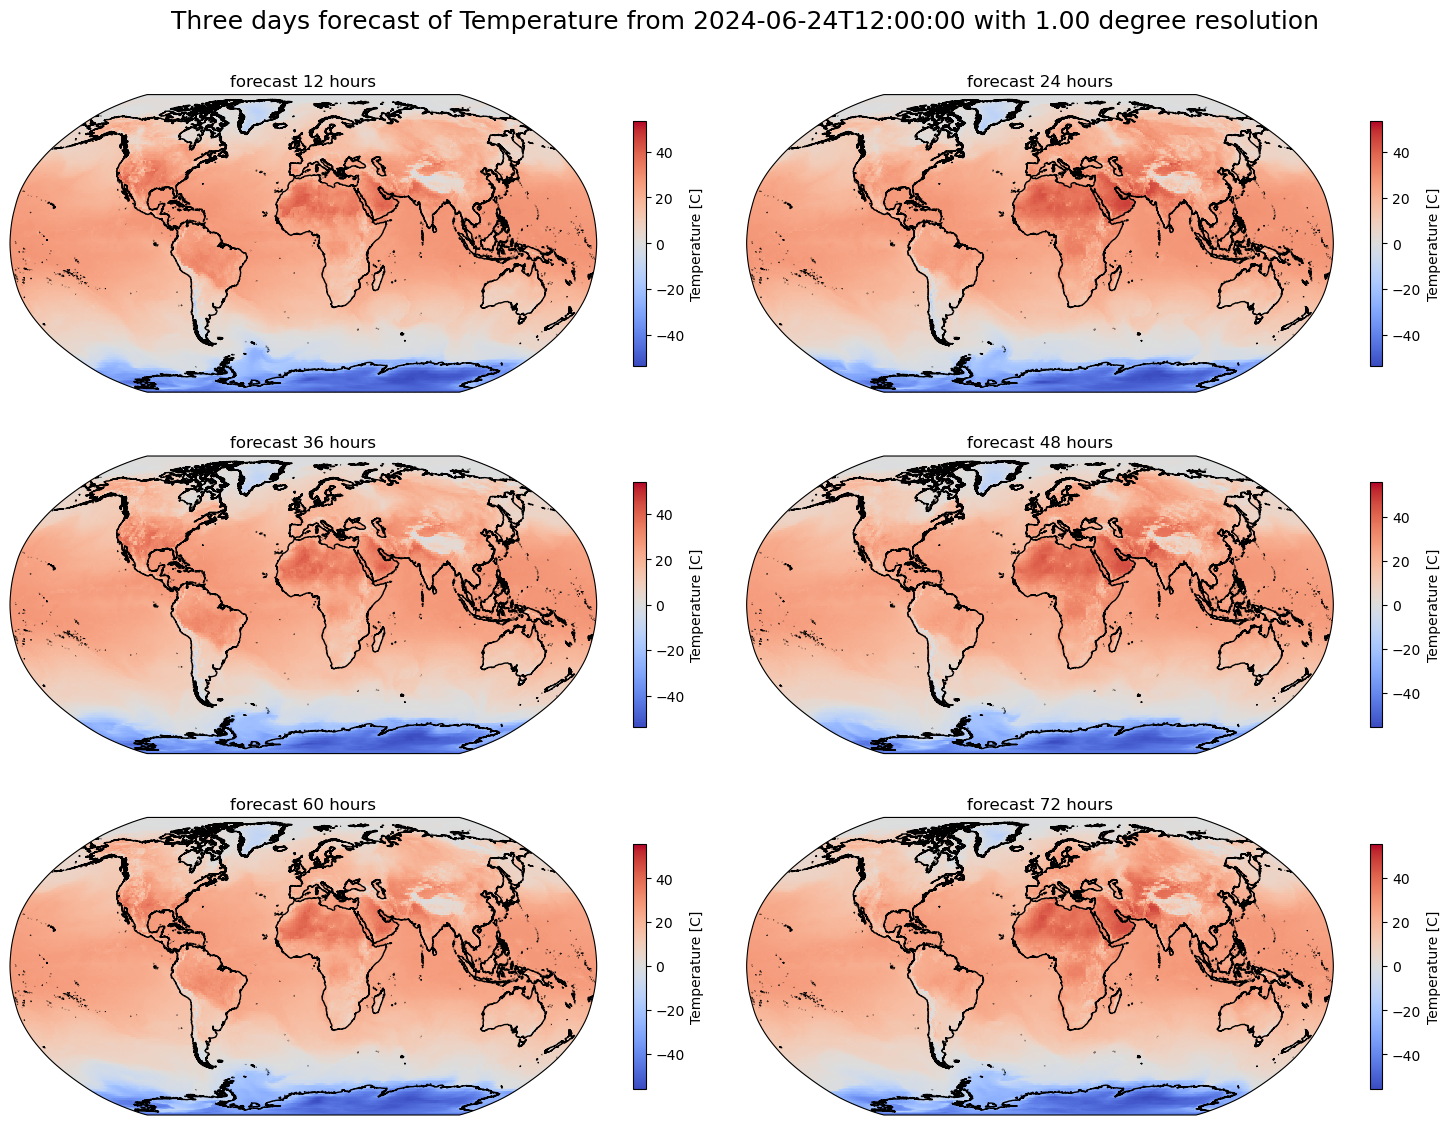

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from alive_progress import alive_bar
from datetime import datetime

# define variables to fetch yesterday data for plotting purpose
yesterday = datetime.now().day - 1
current_month = datetime.now().month
current_year = datetime.now().year
forecast_hours = [x for x in range(12, 72 + 1, 12)]

fig = plt.figure(figsize = (15, 12))
rows = len(forecast_hours) // 2 + len(forecast_hours) % 2
cols = 2

# add alive bar to see the progrees for generating each subplots
with alive_bar(len(forecast_hours), force_tty=True, title='Running', length=20, bar = 'smooth') as bar:
    
    for n, forecast_hour in enumerate(forecast_hours):
        
        URL = file_path(12, forecast_hour, current_year, current_month, yesterday, 1.)

        ds = read_into_xarray_dataset(URL, 'pressureFromGroundLayer')

        ax = plt.subplot(rows, cols, n + 1, projection=ccrs.Robinson())
        
        ax.coastlines(resolution="10m")
        
        # convert temperature measurement from K to C
        (ds['t'] - 273.15).plot(ax = ax,
                                cmap=plt.cm.coolwarm,
                                transform=ccrs.PlateCarree(), 
                                cbar_kwargs={"shrink": 0.6, "label": "Temperature [C]"}
                                )

        plt.title(f"forecast {ds.step.values.astype('timedelta64[h]')}")  

        plt.grid(False)

        bar()

plt.suptitle(f"Three days forecast of Temperature from " 
             f"{ds.time.values.astype('datetime64[s]')} " 
             f"with 1.00 degree resolution", 
             size = 18
             )

plt.subplots_adjust(top = 0.95)
plt.tight_layout()

Loop through all different resolution degrees to see the difference of picture clarity

Running |████████████████████| 3/3 [100%] in 1:12.0 (0.03/s)                    


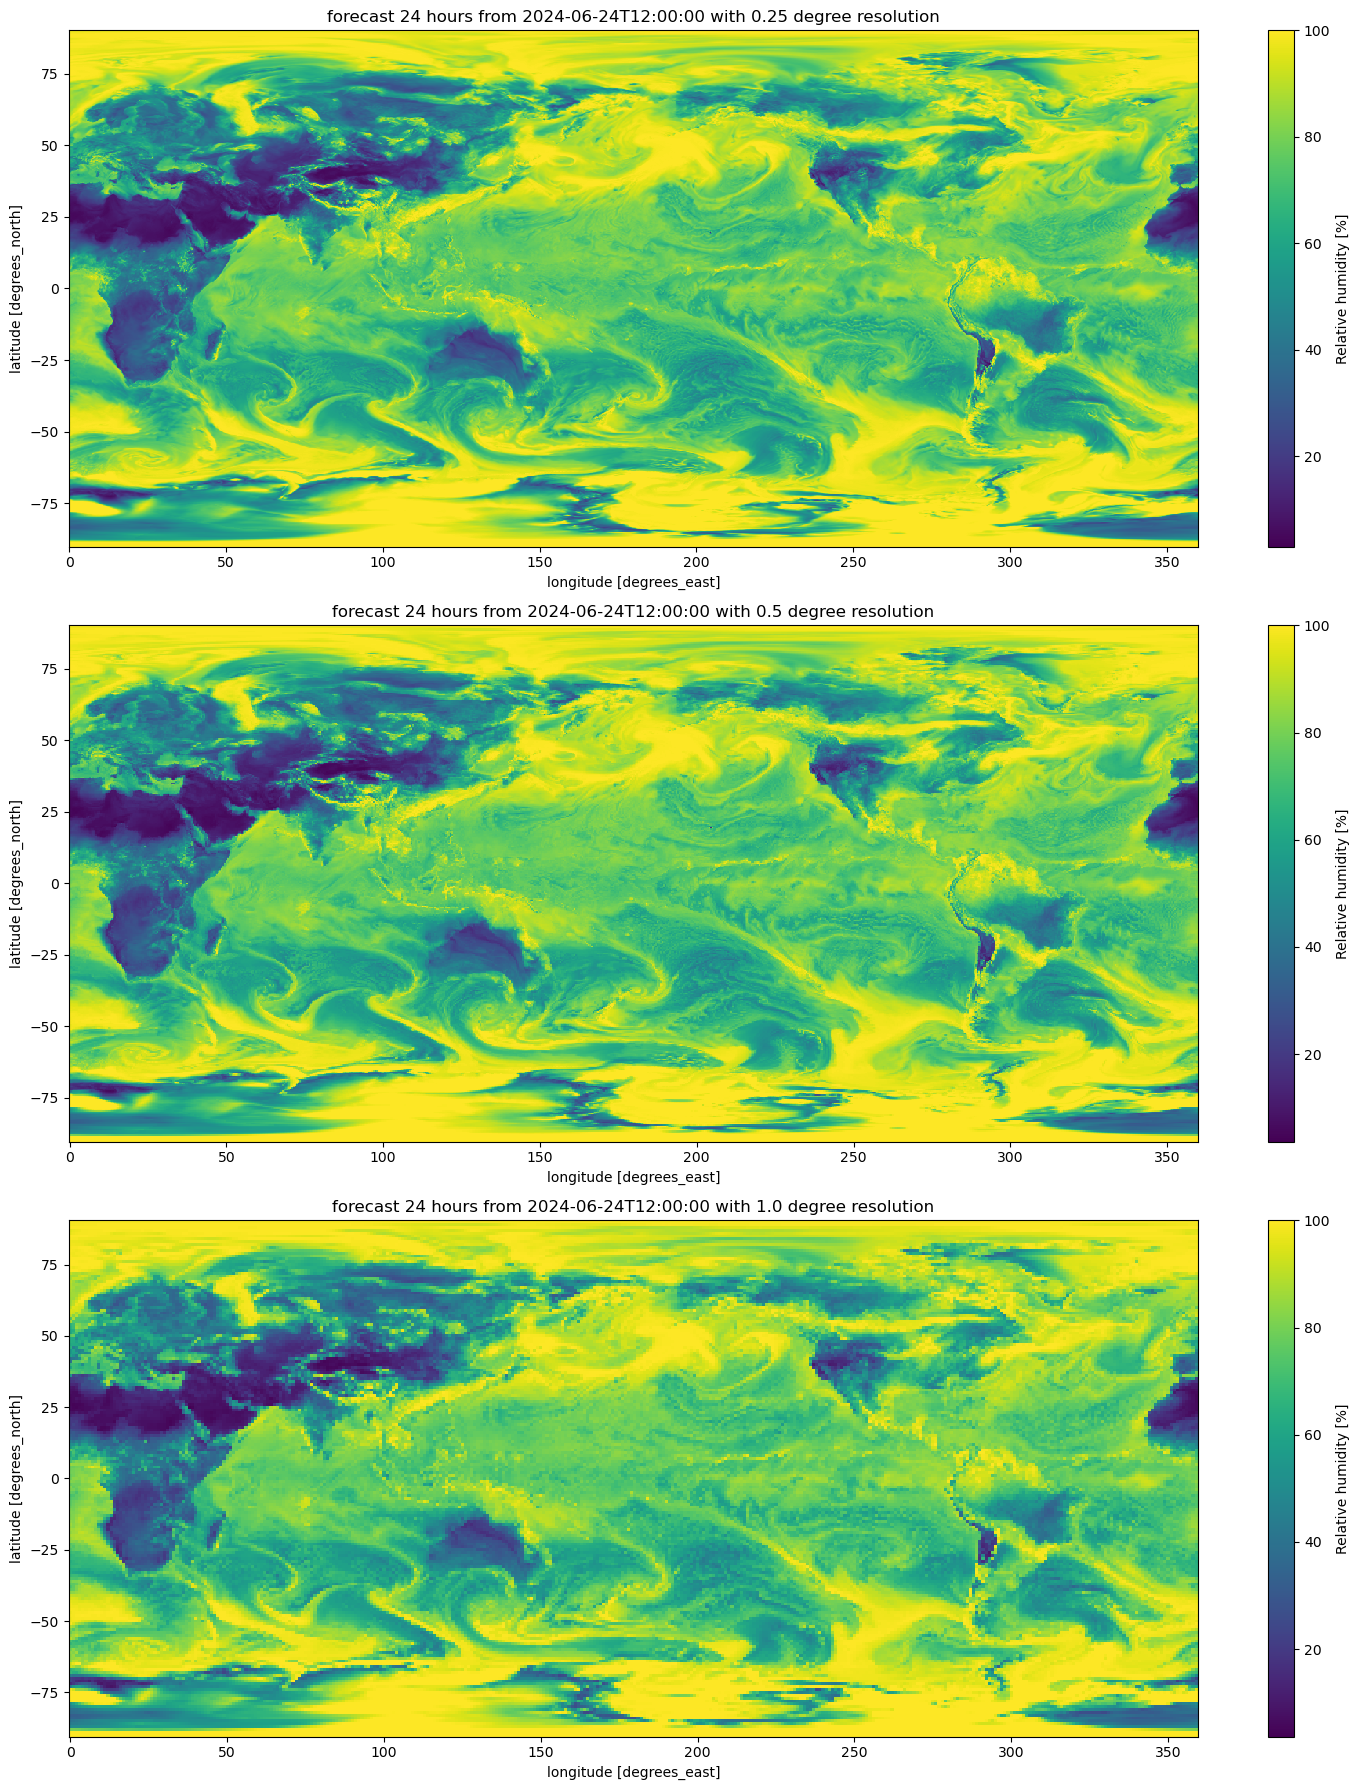

In [8]:
fig = plt.figure(figsize=(15, 18))

resolution_degrees = [0.25, 0.5, 1.]

with alive_bar(len(resolution_degrees), force_tty=True, title='Running', length=20, bar = 'smooth') as bar:
    
    for n, resolution_degree in enumerate(resolution_degrees):
        
        URL = file_path(12, 24, current_year, current_month, yesterday, resolution_degree)

        ds = read_into_xarray_dataset(URL, 'pressureFromGroundLayer')

        ax = plt.subplot(3, 1, n + 1)
        
        ds['r'].plot(ax = ax)

        plt.title(f"forecast {ds.step.values.astype('timedelta64[h]')} " 
                  f"from {ds.time.values.astype('datetime64[s]')} " 
                  f"with {resolution_degree} degree resolution"
                  )

        plt.grid(False)  

        bar()

plt.tight_layout()

Focus on United States, add states and borders using `cartopy.feature` to make it more aesthetically appealing

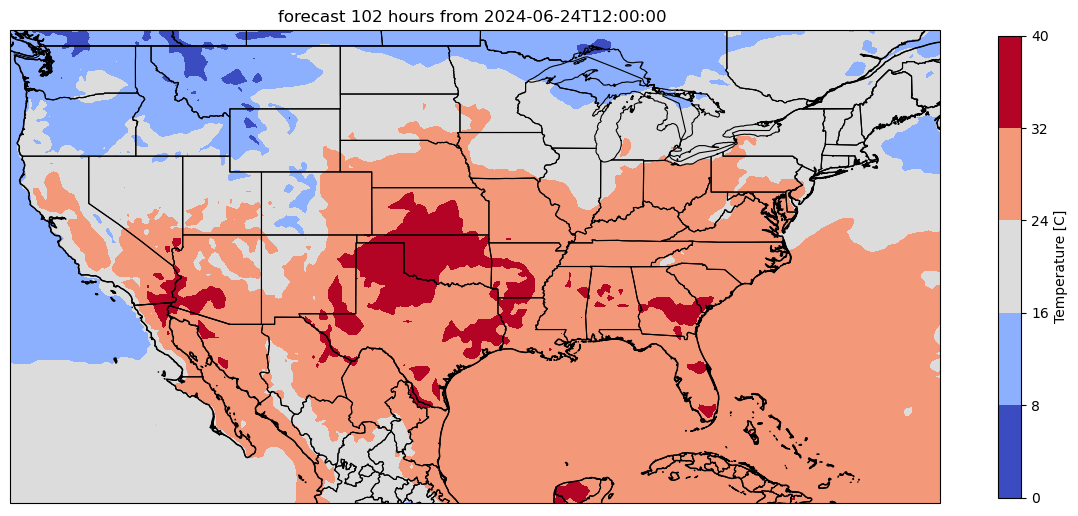

In [9]:
import cartopy.feature as cfeature

URL = file_path(cycle_runtime=12, forecast_hour=102, year=current_year, month=current_month, day=yesterday, resolution_degree=0.25)
ds = read_into_xarray_dataset(URL, 'pressureFromGroundLayer')

fig = plt.figure(figsize = (15, 10))
ds_usa = ds.sel(latitude = slice(50, 20), longitude = slice(235, 294))
ax = plt.axes(projection=ccrs.PlateCarree())
(ds_usa['t'] - 273.15).plot.contourf(
                            ax = ax,
                            cmap = plt.cm.coolwarm,
                            transform = ccrs.PlateCarree(), 
                            cbar_kwargs={"shrink": 0.6, "label": "Temperature [C]"}
                            )
ax.coastlines()
ax.add_feature(cfeature.STATES.with_scale('10m'), zorder=3, linewidth=0.8, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

plt.title(f"forecast {ds_usa.step.values.astype('timedelta64[h]')} " 
          f"from {ds_usa.time.values.astype('datetime64[s]')} " 
         )             

plt.show()

Focus on United States with 30 different meteorological variables  

Running |████████████████████| 30/30 [100%] in 1.2s (25.00/s)                   


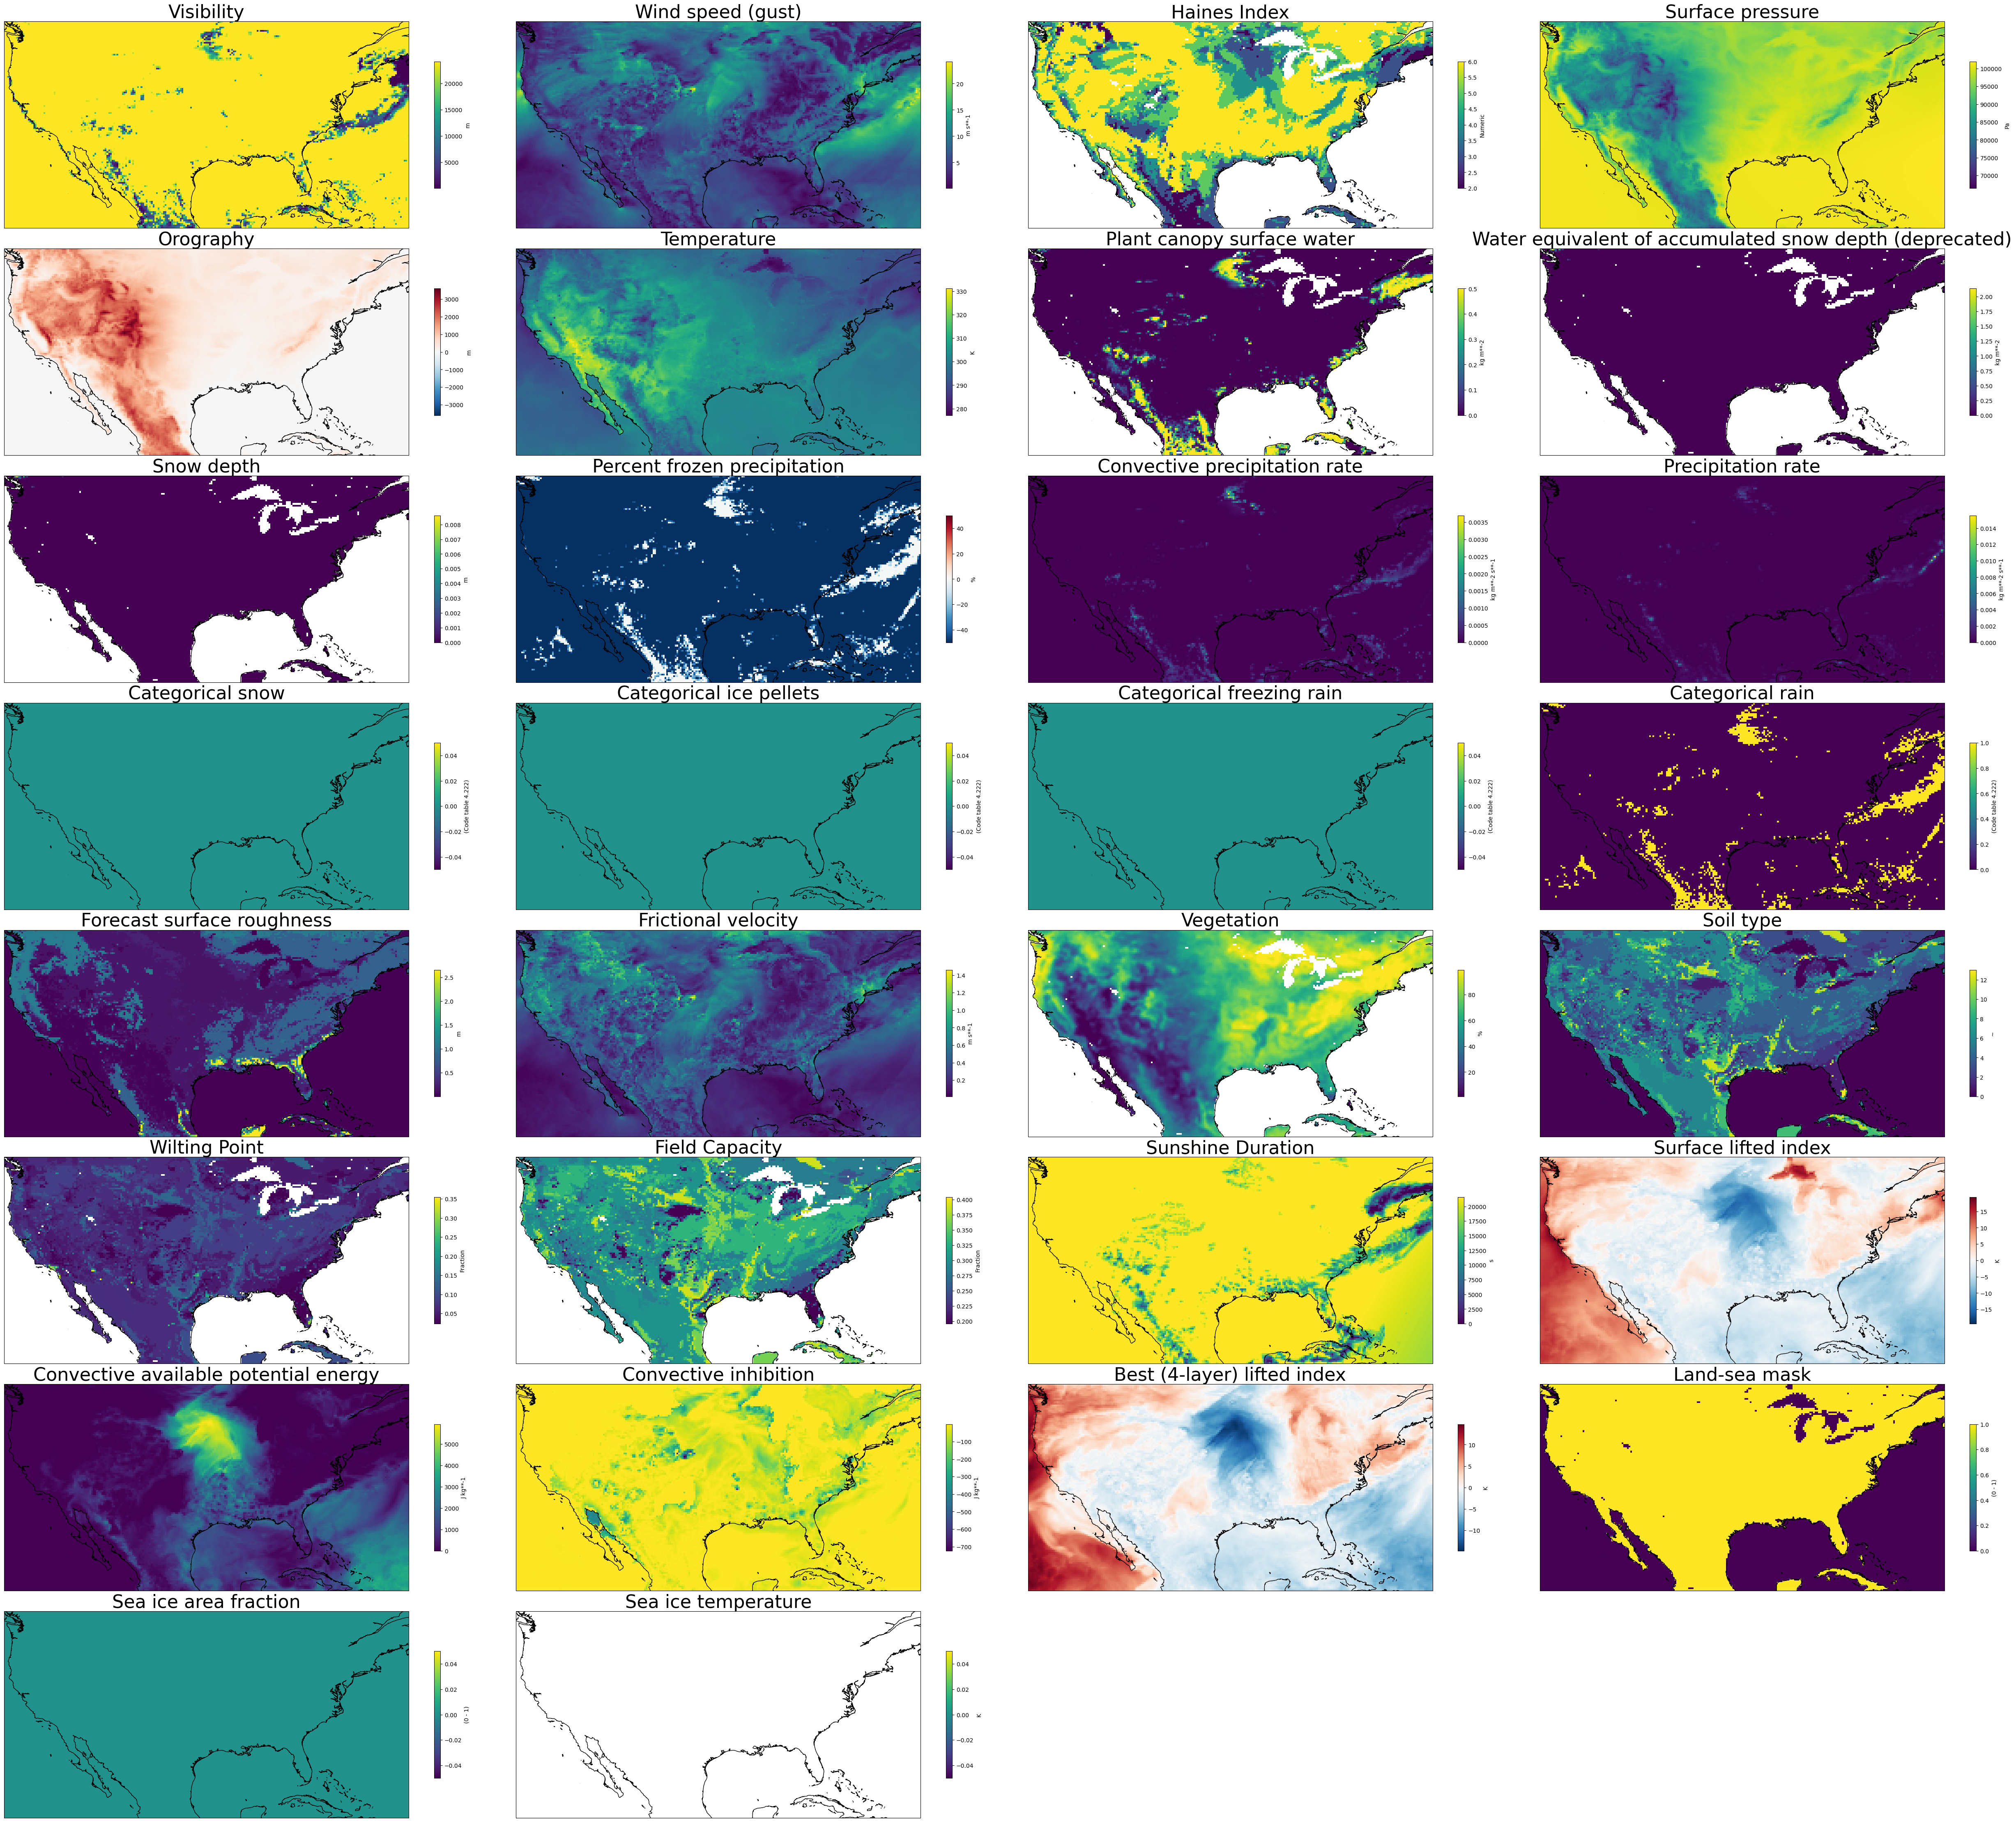

In [10]:
URL = file_path(cycle_runtime=12, forecast_hour=12, year=current_year, month=current_month, day=yesterday, resolution_degree=0.25)
ds = read_into_xarray_dataset(URL, 'surface', 'instant')

# filter out unknown data variable
filtered_vars = [var for var in ds.data_vars if var != 'unknown']

fig = plt.figure(figsize = (50, 50))

cols = 4
rows = len(filtered_vars) // cols + len(filtered_vars) % cols

ds_usa = ds.sel(latitude = slice(50, 20), longitude = slice(235, 294))

with alive_bar(len(filtered_vars), force_tty=True, title='Running', length=20, bar = 'smooth') as bar:
    
    for n, var in enumerate(filtered_vars):
        
        ax = plt.subplot(rows, cols, n + 1, projection=ccrs.PlateCarree())
        
        ax.coastlines(resolution="10m")
        
        ds_usa[var].plot(ax = ax,
                        transform=ccrs.PlateCarree(), 
                        cbar_kwargs={"shrink": 0.6, "label" : ds_usa[var].attrs['GRIB_units']}
                        )

        plt.title(f"{ds_usa[var].attrs['long_name']}", fontdict={'fontsize':32})  

        plt.grid(False)

        bar()

plt.tight_layout()

### Animation - Temperature forecasting to 96 hours

In [11]:
import imageio
from typing import List

# define a funtion to generate plot per forecast hour
def make_frame(forecast_hour:List[int]):
    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    cycle_runtime = 12
    resolution_degree = 1.
    
    URL = file_path(cycle_runtime, forecast_hour, current_year, current_month, yesterday, resolution_degree)
    ds = read_into_xarray_dataset(URL, 'pressureFromGroundLayer')

    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines(resolution="10m")
    
    (ds['t'] - 273.15).plot(ax = ax,
                            cmap=plt.cm.coolwarm,
                            transform=ccrs.PlateCarree(), 
                            cbar_kwargs={"shrink": 0.6, "label": "Temperature [C]"}
                            )

    plt.title(f"forecast {ds.step.values.astype('timedelta64[h]')} from {ds.time.values.astype('datetime64[s]')}")  
    plt.grid(False)

    plt.savefig(f'./img/temp_forecast_{forecast_hour}_hours.png', transparent=False, facecolor='white')
    plt.close()  

In [12]:
# generate plots with given forecast hours and save them into .png file
forecast_hour = [x for x in range(3, 96 + 1, 3)]
with alive_bar(len(forecast_hour), force_tty=True, title='Running', length=20, bar = 'smooth') as bar:
    for t in forecast_hour:
        make_frame(t)
        bar()


# use `imageio` to create gif with given plots 
frames = []
for t in forecast_hour:
    image = imageio.v2.imread(f'./img/temp_forecast_{t}_hours.png')
    frames.append(image)

imageio.mimsave('./img/temp_forecast.gif',
                frames,          
                loop = 65535,      
                fps = 2)     

Running |████████████████████| 32/32 [100%] in 5:48.8 (0.09/s)                  


<div align=center>
<img src="./img/temp_forecast.gif"/>
</div>